# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, we will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. We'll compare the system usage between three large cities: New York City, Chicago, and Washington, DC. We'll also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

**Question 1**: What is the distribution of trip durations? What is the distribution of trip quantities by month? What is the quantity of trip durations by day of the week? What are the most popular bike routes? 

<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. Some data wrangling of inconsistencies in timestamp format within each city has already been performed. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 

**Question 2**: However, there is still a lot of data for us to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze.

In [2]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.

In [3]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## set up a DictReader object. ##
        trip_reader = csv.DictReader(f_in)
        
        ## use function on the DictReader object to read the     ##
        ## first trip from the data file and store it in a variable.     ##
        first_trip = next(trip_reader)
    
        ## use pprint library to print the first trip. ##
        pprint(first_trip)
        
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

<a id='condensing'></a>
### Condensing the Trip Data

It should be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

We will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, we will convert the Washington labels to match the other two.


**Question 3a**: We will complete the helper functions in the code cells below to address each of the cleaning tasks described above.

In [4]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    """

    if city == 'Washington':
        duration = float(datum['Duration (ms)'])/60000
    else:
        duration = float(datum['tripduration'])/60
    
    return duration


# Some tests to check that the code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# we printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [5]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    """
    weekdays = {6: 'Sunday',0: 'Monday',1: 'Tuesday',2: 'Wednesday',3: 'Thursday',4: 'Friday',5: 'Saturday'}
    if city == 'NYC':
        trip = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M:%S')
        date_extract = datetime.date(trip)
        time_extract = datetime.time(trip)
        month = int(date_extract.month)
        hour = int(time_extract.hour)
        day_of_week = weekdays[datetime.weekday(datetime.date(trip))]
    elif city == 'Chicago':
        trip = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M')
        date_extract = datetime.date(trip)
        time_extract = datetime.time(trip)
        month = int(date_extract.month)
        hour = int(time_extract.hour)
        day_of_week = weekdays[datetime.weekday(datetime.date(trip))]
    elif city == 'Washington':
        trip = datetime.strptime(datum['Start date'], '%m/%d/%Y %H:%M')
        date_extract = datetime.date(trip)
        time_extract = datetime.time(trip)
        month = int(date_extract.month)
        hour = int(time_extract.hour)
        day_of_week = weekdays[datetime.weekday(datetime.date(trip))]
        
    return (month, hour, day_of_week)


# Some tests to check that the code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# we printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [6]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    if city == 'Washington':
        if datum['Member Type'] == 'Registered':
            user_type = 'Subscriber'
        else:
            user_type = 'Customer'
    else:
        user_type = datum['usertype']
    
    return user_type


# Some tests to check that the code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# we printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

**Question 3b**: Now, we use the helper functions above to create a condensed data file for each city consisting only of the data fields indicated above. 

In [7]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## set up csv DictReader object ##
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed data point
            new_point = {}

            ## use the helper functions to get the cleaned data from original data dictionaries. ##
            new_point['duration'] = round(duration_in_mins(row, city),4)
            new_point['month'] = time_of_trip(row, city)[0]
            new_point['hour'] = time_of_trip(row, city)[1]
            new_point['day_of_week'] = time_of_trip(row, city)[2]
            new_point['user_type'] = type_of_user(row, city)
            #new_point dictionary - 1 dictionary per row containing 3 key value pairs.
            
            ## TODO: write the processed information to the output file.     ##
            trip_writer.writerow(new_point)      

In [8]:
# checking our work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.1231'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.4333'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.9833'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that we have the data collected and wrangled, we'll start exploring the data. In this section we'll write some code to compute descriptive statistics from the data. We'll also use the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. Below we'll write a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. Then we'll run the function on the data.

**Question 4a**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

**Answer**: The city with the highest number of trips is NYC. The city with the highest proportion of trips made by subscribers is NYC. The city with the highest proportion of trips made by customers is Chicago.

In [9]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_sub_trips = 0
        n_cust_trips = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_sub_trips += 1
            else:
                n_cust_trips += 1
        
        # compute total number of rides
        n_tot_trips = n_sub_trips + n_cust_trips

        # return dictionary with last 3 computations
        return(n_sub_trips, n_cust_trips, n_tot_trips)

In [10]:
city_files = {'Washington': './data/Washington-2016-Summary.csv',
             'Chicago': './data/Chicago-2016-Summary.csv',
             'NYC': './data/NYC-2016-Summary.csv'}

for city, filename in city_files.items():
    num_trips = number_of_trips(filename)
    proportion_subscribers = round((num_trips[0])/(num_trips[2]),4)
    proportion_customers = round((num_trips[1])/(num_trips[2]),4)
    tripnums_dict = {"num trips":num_trips[2], "proportion subscribers":proportion_subscribers, "proportion customers": proportion_customers}
    print(city,tripnums_dict)

Washington {'num trips': 66326, 'proportion subscribers': 0.7803, 'proportion customers': 0.2197}
Chicago {'num trips': 72131, 'proportion subscribers': 0.7623, 'proportion customers': 0.2377}
NYC {'num trips': 276798, 'proportion subscribers': 0.8884, 'proportion customers': 0.1116}


Now, we will continue investigating properties of the data.

**Question 4b**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

**Answer**: Average trip length for each city: Washington - 18.93 min, Chicago - 16.56 min, NYC - 15.81 min. Proportion of rides longer than 30 min for each city: Washington - 10.84%, Chicago - 8.33%, NYC - 7.3%

In [11]:
## FYI: The csv module reads in all of the data as strings, including  ##
## numeric values. We will need a function to convert the strings      ##
## into an appropriate numeric type before aggregating data.          ##

def ride_durations(filename):
    """
    This function reads in a file with trip data and reports the average trip duration by city
    and the proportion of ride with a duration over 30 min.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count & sum variables
        ride_over30_ct = 0
        normal_ride_ct = 0
        duration_totals = 0
        
        # tally up ride duration totals & sum of all ride durations
        for row in reader:
            duration = float(row['duration'])
            duration_totals += duration
            if duration > 30:
                ride_over30_ct += 1
            else:
                normal_ride_ct += 1
                
        #add up total_rides    
        total_ride_ct = ride_over30_ct + normal_ride_ct
        
        #proportion of ride over 30 min
        p_over30 = ride_over30_ct/total_ride_ct
        p_over30 = round(p_over30, 5)
        
        #calculate average of all trips
        av_trip_dur = round((duration_totals/total_ride_ct),4)
      
        return (p_over30, av_trip_dur)

In [12]:
#parse by city summary data file to get the above computations by city
city_files = {'Washington': './data/Washington-2016-Summary.csv',
             'Chicago': './data/Chicago-2016-Summary.csv',
             'NYC': './data/NYC-2016-Summary.csv'}

for city, filename in city_files.items():
    durations_dict = {"proportion trips 30+ min": ride_durations(filename)[0], "average trip duration": ride_durations(filename)[1]}
    print(city, durations_dict)

Washington {'proportion trips 30+ min': 0.10839, 'average trip duration': 18.9329}
Chicago {'proportion trips 30+ min': 0.08332, 'average trip duration': 16.5636}
NYC {'proportion trips 30+ min': 0.07302, 'average trip duration': 15.8126}


**Question 4c**: Digging deeper into the question of trip duration based on ridership, we'll choose one city - NYC. Within that city, which type of user takes longer rides on average: Subscribers or Customers?

**Answer**: NYC {'subscriber average': 13.6808, 'customer average': 32.776}

In [13]:
def user_ride_durations(filename):
    """
    This function reads in a file with trip data and reports the average trip duration within a city
    by member type.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        ##filter between subscribers and customers
        ##then calculate the average trip duration of each group
        
        #subscriber and customer counts
        subs_durations = 0
        cust_durations = 0
        
        for row in reader:
            if row['user_type'] == 'Subscriber':
                subs_durations += float(row['duration'])
            else:
                cust_durations += float(row['duration'])
                
        #subscriber and customer averages    
        subs_av = round((subs_durations/(number_of_trips(filename)[0])),4)
        cust_av = round((cust_durations/(number_of_trips(filename)[1])),4)
        
        av_dict = {"subscriber average": subs_av, "customer average": cust_av}
            
        return av_dict

In [14]:
city, filename = ('NYC','./data/NYC-2016-Summary.csv')

print(city, user_ride_durations(filename))

NYC {'subscriber average': 13.6808, 'customer average': 32.776}


<a id='visualizations'></a>
### Visualizations

This last set of values pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. Now we start using `matplotlib`. The cell below will load a sample library to generate an example plot.

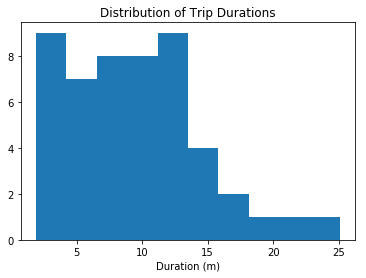

In [15]:
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed inline with the notebook.
%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In the above cell, we collected fifty trip times in a list, and passed this list as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.

We'll now use these functions to create a histogram of the trip times for NYC.

In [16]:
def all_durations(filename):
    """
    This function reads in a file with trip data and reports all trip durations.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        #create empty list in which to loop in all trip durations
        list_durations = []
        
        #loop through each trip, pull the duration and append to list_durations
        for row in reader:
            if float(row['duration']) < 100:
                list_durations.append(float(row['duration']))
            
        return list_durations

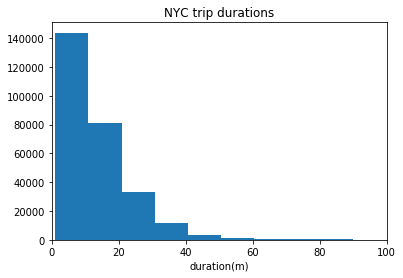

In [17]:
#using the function above to visualize all the trip durations for NYC
city, filename = ('NYC','./data/NYC-2016-Summary.csv')

plt.hist(all_durations(filename))
plt.title('NYC trip durations')
plt.xlabel('duration(m)')
plt.xlim([0,100])
plt.show()

The plot consists of one extremely tall bar on the left, maybe a very short second bar, and a whole lot of empty space in the center and right. Looking at the duration values on the x-axis suggests that there are some highly infrequent outliers in the data. Let's use some additional parameters with the `.hist()` function to limit the range of data that is plotted.

**Question 5**: Use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers in NYC. Do the same thing for only the Customers. Add limits to the plots so that only trips of duration less than 75 minutes are plotted. As a bonus, set the plots up so that bars are in five-minute wide intervals. For each group, where is the peak of each distribution? How would you describe the shape of each distribution?

**Answer**: NYC Subscribers peak in trip duration at 5 to 10 minutes and the shape of the distribution is right-skewed. NYC Customers peak in trip duration at 20 to 25 minutes and the shape of the distribution is somewhat symmetric/normal and slightly right-skewed.

In [18]:
def duration_lists(filename):
    """
    This function reads in a file with trip data and returns a list of trip durations based on user type.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        ##filter between subscribers and customers and create lists of all durations for each
        subs_durations = []
        cust_durations = []
        
        for row in reader:
            if row['user_type'] == 'Subscriber' and float(row['duration']) < 75:
                subs_durations.append(float(row['duration']))
            elif row['user_type'] == 'Customer' and float(row['duration']) < 75:
                cust_durations.append(float(row['duration']))
                
        return (subs_durations, cust_durations)

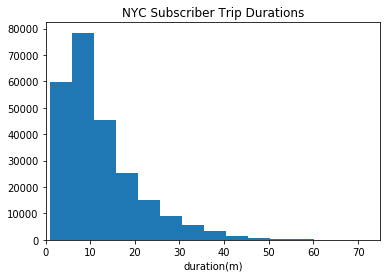

In [19]:
#use the above function to plot the subscriber and customer durations on histograms in the following two cells
city, filename = ('NYC','./data/NYC-2016-Summary.csv')

plt.hist(duration_lists(filename)[0], bins = 15)
plt.title('NYC Subscriber Trip Durations')
plt.xlabel('duration(m)')
plt.xlim([0,75])
plt.show()

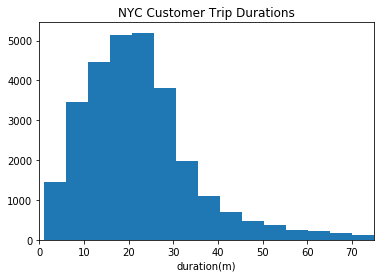

In [20]:
plt.hist(duration_lists(filename)[1], bins = 15)
plt.title('NYC Customer Trip Durations')
plt.xlabel('duration(m)')
plt.xlim([0,75])
plt.show()

<a id='eda_continued'></a>
## Performing Additional Analysis

So far, we've performed an initial exploration into the data available. We compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For NYC, we investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. Now we continue the exploration.

**Question 6**: How does ridership differ by month? Which month has the highest ridership? How about for day of the week? What does this look like for each city?

**Answer**: Keeping in mind that the data we have is just for the year 2016 - Monthly Trips: For Washington, monthly ridership increased a lot in the summer months compared to the winter months. The distribution is pretty symmetric, with the ridership peak occurring in June and July. 
For Chicago, ridership also increases a lot in the summer months compared to the winter months. The distribution is also pretty symmetric, with the ridership peak occurring in July. NYC has the most increased ridership months in the Fall season, compared to the winter months. The distribution is also somewhat normal, with September being the peak month.

Weekday Trips: For Washington, aggregate ridership on all weekends in 2016 was between 8,200 and 8,900. On weekdays, it was between 9,300 and 10,100. So it looks like there was more ridership on weekdays last year in Washington.
For Chicago, aggregate ridership on Mondays, Tuesday and Fridays was the highest - between 10,700 and 11,300. The other days of the week had slightly lower ridership between 9,600 and 10,000.
For NYC, weekends had aggregate lower ridership than the other days of the week, between 31,300 and 33,400. The weekdays had aggregrate higher ridership, peaking on Wednesday and Thursday - going between 39,300 and 44,700.

In [21]:
##write function counting the number of trips per month for each city
def monthly_trips(filename):
    """
    This function reads in a file with trip data and returns 
    trip counts by month.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        months = list(range(1,13))
        monthly_ct = [0]*len(months)
        
        #loop through each row in file and add counts to each month for each trip occuring in that month
        for row in reader:
            for month in months:
                if int(row['month']) == month:
                    monthly_ct[month-1] += 1
                    
        return monthly_ct

#set up axes for the plots below
months_n = [0,1,2,3,4,5,6,7,8,9,10,11]
months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

[2434, 2854, 5571, 5602, 5768, 7320, 7341, 7198, 6878, 6792, 5214, 3354]


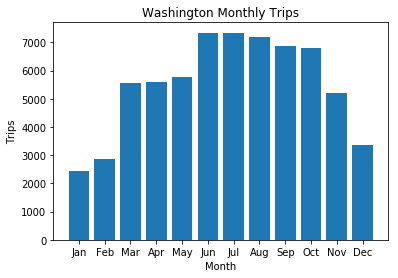

In [22]:
#create bar chart for each city's monthly trips in the next 3 cells
Washington = './data/Washington-2016-Summary.csv'
print(monthly_trips(Washington))

plt.bar(months_n, monthly_trips(Washington))
plt.xticks(months_n, months)
plt.title('Washington Monthly Trips')
plt.ylabel('Trips')
plt.xlabel('Month')
plt.show()

[1901, 2394, 3719, 4567, 7211, 9794, 10286, 9810, 8700, 7160, 4811, 1778]


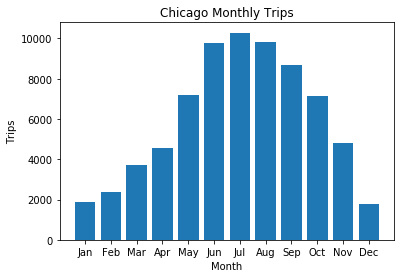

In [23]:
Chicago = './data/Chicago-2016-Summary.csv'
print(monthly_trips(Chicago))

plt.bar(months_n, monthly_trips(Chicago))
plt.xticks(months_n, months)
plt.title('Chicago Monthly Trips')
plt.ylabel('Trips')
plt.xlabel('Month')
plt.show()

[10180, 11170, 18413, 20160, 24455, 29242, 27522, 31104, 32699, 31519, 24148, 16186]


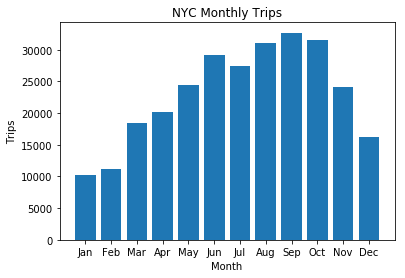

In [24]:
NYC = './data/NYC-2016-Summary.csv'
print(monthly_trips(NYC))

plt.bar(months_n, monthly_trips(NYC))
plt.xticks(months_n, months)
plt.title('NYC Monthly Trips')
plt.ylabel('Trips')
plt.xlabel('Month')
plt.show()

In [25]:
##write function counting the number of trips each day of the week for each city
def weekday_trips(filename):
    """
    This function reads in a file with trip data and returns 
    trip counts by day of the week.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
       
        weekday_ct = [0,0,0,0,0,0,0]
        
        #loop through each row in file and add counts to each month for each trip occuring in that month
        for row in reader:
            if row['day_of_week'] == 'Monday':
                weekday_ct[0] += 1
            elif row['day_of_week'] == 'Tuesday':
                weekday_ct[1] +=1
            elif row['day_of_week'] == 'Wednesday':
                weekday_ct[2] += 1
            elif row['day_of_week'] == 'Thursday':
                weekday_ct[3] += 1
            elif row['day_of_week'] == 'Friday':
                weekday_ct[4] += 1
            elif row['day_of_week'] == 'Saturday':
                weekday_ct[5] += 1
            elif row['day_of_week'] == 'Sunday':
                weekday_ct[6] += 1
                
        return weekday_ct

#set up axes for bar plots below
weekdays_n = [0,1,2,3,4,5,6]
weekdays = ('Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun')

[9394, 9748, 10103, 9984, 9970, 8900, 8227]


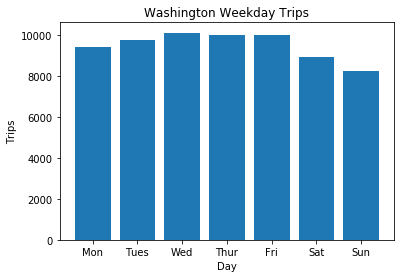

In [26]:
#create bar chart for each city's monthly trips in the next 3 cells
Washington = './data/Washington-2016-Summary.csv'
print(weekday_trips(Washington))

plt.bar(weekdays_n, weekday_trips(Washington))
plt.xticks(weekdays_n, weekdays)
plt.title('Washington Weekday Trips')
plt.ylabel('Trips')
plt.xlabel('Day')
plt.show()

[11286, 10911, 9604, 10008, 10741, 9927, 9654]


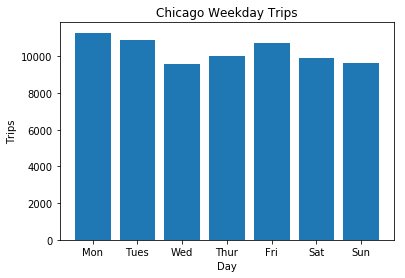

In [27]:
Chicago = './data/Chicago-2016-Summary.csv'
print(weekday_trips(Chicago))

plt.bar(weekdays_n, weekday_trips(Chicago))
plt.xticks(weekdays_n, weekdays)
plt.title('Chicago Weekday Trips')
plt.ylabel('Trips')
plt.xlabel('Day')
plt.show()

[39340, 42405, 44629, 44330, 41389, 33353, 31352]


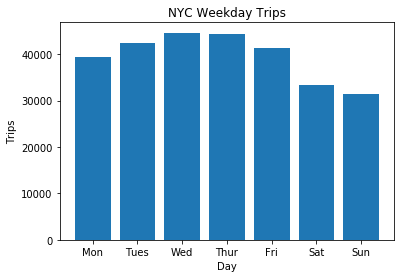

In [28]:
NYC = './data/NYC-2016-Summary.csv'
print(weekday_trips(NYC))

plt.bar(weekdays_n, weekday_trips(NYC))
plt.xticks(weekdays_n, weekdays)
plt.title('NYC Weekday Trips')
plt.ylabel('Trips')
plt.xlabel('Day')
plt.show()

<a id='conclusions'></a>
## Conclusions

This is only a sampling of the data analysis process: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, we might want to draw conclusions about the data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?